# Part I - Loan Data Exploration
## by Kimberly Gatti

## Introduction
> This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.  



## Preliminary Wrangling


In [34]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [35]:
# load in the dataset into a pandas dataframe
df=pd.read_csv('prosperLoanData.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21,22,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
#Later in the project, I want to use the Loan Status column. This column as a number of Past Due columns by different lengths of time. I've combined them into one category.
#make a copy of the column
df['LoanStatus_new']=df['LoanStatus']

#change the values containing Past Due to past due
mask=df['LoanStatus_new'].str.contains("Past Due")
df.loc[mask,'LoanStatus_new']="Past Due"

In [37]:
ordinal_var_dict = {'IncomeRange': ['$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+','Not displayed','nan'],
                   'LoanStatus_new': ['Current','Completed','FinalPaymentInProgress','Past Due','Chargedoff','Defaulted']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [38]:
#get rid of the spaces in some of the column names
df.columns = [c.replace(' ', '_') for c in df.columns]

In [39]:
# high-level overview of data shape and composition
print(df.shape)
print(df.dtypes)
print(df.head(10))

(85665, 82)
ListingKey                               object
ListingNumber                             int64
ListingCreationDate                      object
CreditGrade                              object
Term                                      int64
LoanStatus                               object
ClosedDate                               object
BorrowerAPR                             float64
BorrowerRate                            float64
LenderYield                             float64
EstimatedEffectiveYield                 float64
EstimatedLoss                           float64
EstimatedReturn                         float64
ProsperRating_(numeric)                 float64
ProsperRating_(Alpha)                    object
ProsperScore                            float64
ListingCategory_(numeric)               float64
BorrowerState                            object
Occupation                               object
EmploymentStatus                         object
EmploymentStatusDuration    

In [40]:
df.BorrowerRate.describe()

count    85665.000000
mean         0.192524
std          0.074836
min          0.000000
25%          0.133400
50%          0.183000
75%          0.250000
max          0.497500
Name: BorrowerRate, dtype: float64

In [41]:
df.LoanStatus.value_counts()

Current                   42575
Completed                 28650
Chargedoff                 8982
Defaulted                  3750
Past Due (1-15 days)        607
Past Due (31-60 days)       268
Past Due (61-90 days)       232
Past Due (91-120 days)      220
Past Due (16-30 days)       201
FinalPaymentInProgress      163
Past Due (>120 days)         14
Cancelled                     3
Name: LoanStatus, dtype: int64

### What is the structure of your dataset?

> There are 85,665 detailed loans in this dataset and 81 columns. That is alot of columns! Many are numeric but some are categorical, like Loan Status, Borrower State, Listing Category, Occupation, and Employment status. The columns break down into two parts, Borrower information and Loan information

### What is/are the main feature(s) of interest in your dataset?

> I'm interested in exploring if there are any key indicators that affect the interest rate of a loan. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> There are so many records that appear to have been collected that narrowing it down to just a few will be necessary.  I assume that the income range will affect the interest rate. I would also assume that the relationship between previous delinquencies, on-time payments, and credit score will have a high correlation to the resulting interest rate. I'm curious about the effect of Listing Category and whether something so important yet optional as adoption for example would lend itself to a higher interest rate. An added curiosity would be to decide whether the higher the interest rate, the higher the default rate.  

## Univariate Exploration

> Let's start with looking at the main variable of curiousity: interest rate



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


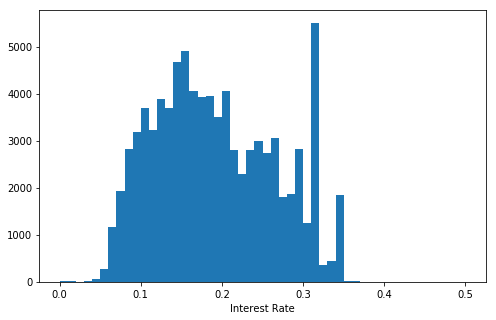

In [42]:
# start with a standard-scaled plot of Interest rate
binsize = .01
bins = np.arange(0, df['BorrowerRate'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'BorrowerRate',bins=bins)
plt.xlabel('Interest Rate')
plt.show()

>The feature that stands out the most is the spike around 0.32. This curve has two modes but I expected something more of a normal curve. There is certainly some outliers to the right of the data and the range being 0.5 and the Q4 covering .25 of that indicates that we are skewed right. 

>Let's look at the first factor to consider with interest rates: Income

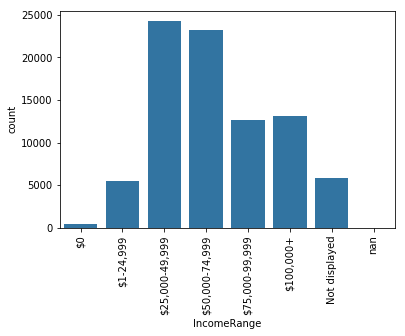

In [43]:
#plot of income range

default_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'IncomeRange',color = default_color);
plt.xticks(rotation=90);

(0, 25)

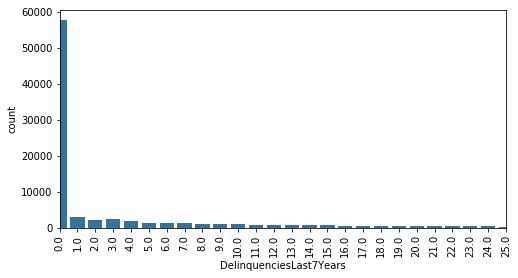

In [44]:
#The distribution is skewed slightly to the right as well. 
#Let's next look at deliquencies. First, the deliquencies in the last 7 years

plt.figure(figsize=(8,4))
sb.countplot(data = df, x = 'DelinquenciesLast7Years',color = default_color);
plt.xticks(rotation=90);
plt.xlim([0, 25])

#Because of how the trend continues out to about 100, I decided to just see the first 25 delinquencies so the graph was easier to read. 
#Obviously there is a significant amount of data with 0 delinquencies. 


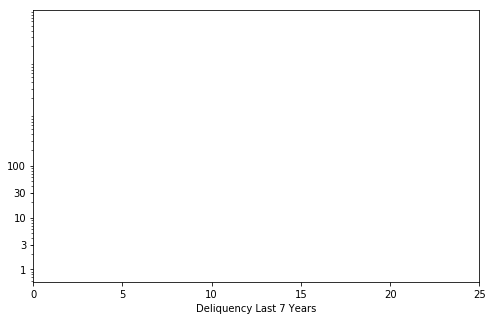

In [47]:
#It didn't expect such a large count at 0
#I can see the trend is decreasing as expected.
#**Going to a log scale for the y
plt.figure(figsize=[8, 5])
categories = df['DelinquenciesLast7Years'].value_counts().index
counts = df['DelinquenciesLast7Years'].value_counts().values
plt.bar(categories, counts, width=1)
plt.yscale('log')
plt.xlim([0, 25])
plt.yticks([1, 3, 10,30, 100],['1', '3','10','30','100'])
plt.xlabel('Deliquency Last 7 Years')
plt.show()

<Container object of 123 artists>

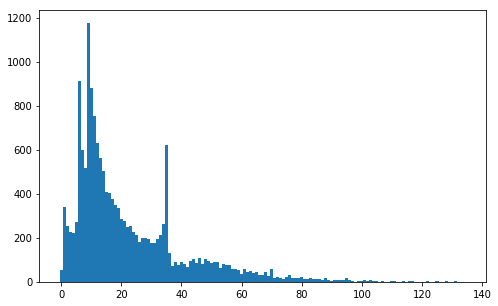

In [48]:
#Next we can look at On Time Prosper Payments
#I'm interested in this to see if there is any correlation between interest rate and on time payments after the loan is made.

plt.figure(figsize=[8, 5])

categories = df['OnTimeProsperPayments'].value_counts().index
counts = df['OnTimeProsperPayments'].value_counts().values
plt.bar(categories, counts, width=1)

<Container object of 3 artists>

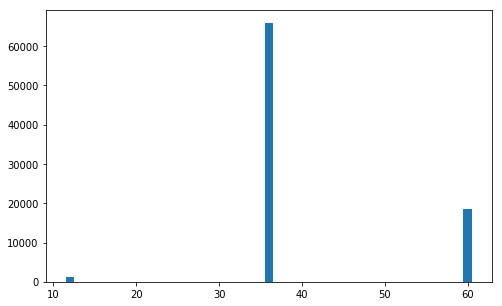

In [49]:
#I didn't expect this to drop off so quickly with ontime payments.I'm assuming the spike at 10 and 36 are due to the terminating of a loan interval but I would have expected another spike at 60. 
#lets explore that.
#let's look at loan term
plt.figure(figsize=[8, 5])

categories = df['Term'].value_counts().index
counts = df['Term'].value_counts().values
plt.bar(categories, counts, width=1)

In [50]:
#Yes, the spikes in the spikes of on-time-payments correspond to the terms set on the loans:12,36,and 60

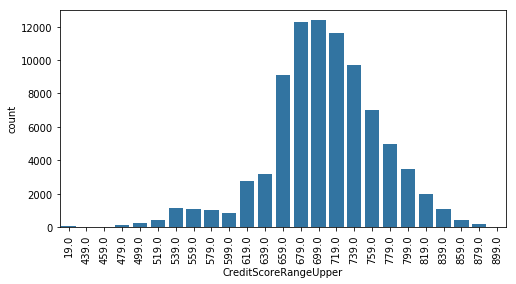

In [51]:
#credit score. I'm using the upper limit. 
plt.figure(figsize=(8,4))
sb.countplot(data = df, x = 'CreditScoreRangeUpper',color = default_color);
plt.xticks(rotation=90);
#plt.xlim([0, 25])

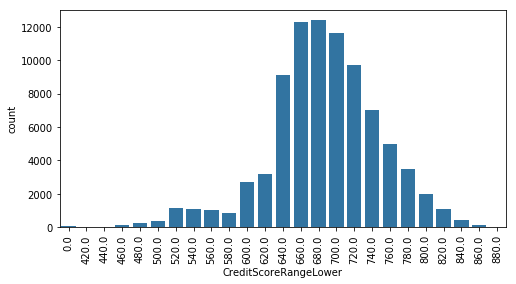

In [52]:
#I just as easily could use the lower credit score or the average which appears to be about the same. 
plt.figure(figsize=(8,4))
sb.countplot(data = df, x = 'CreditScoreRangeLower',color = default_color);
plt.xticks(rotation=90);
#plt.xlim([0, 25])

In [53]:
#This is interesting that this a normal distribution when the actual Interest rate offered had a spike. 

<Container object of 21 artists>

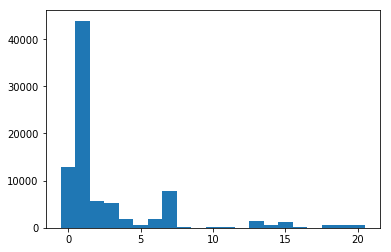

In [54]:
#Interested in Listing Category 

categories = df['ListingCategory_(numeric)'].value_counts().index
counts = df['ListingCategory_(numeric)'].value_counts().values
plt.bar(categories, counts, width=1)




In [55]:
#I expected these to be somewhat randomly distributed with a few taking most of the data. 
#1 corresponds to debt consolidation, the other spike at 7 corresponds to "other"

<Container object of 2000 artists>

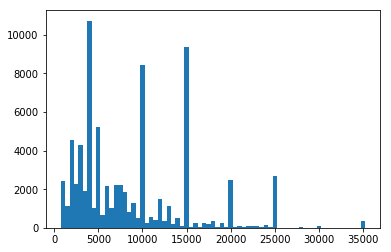

In [56]:
#Loan Amount: 

categories = df['LoanOriginalAmount'].value_counts().index
counts = df['LoanOriginalAmount'].value_counts().values
plt.bar(categories, counts, width=500)

In [57]:
#It definitely makes sense that the spikes are happening at multiples of $5000
df.LoanOriginalAmount.describe()

count    85664.000000
mean      8338.683344
std       6240.574963
min       1000.000000
25%       4000.000000
50%       6500.000000
75%      12000.000000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

In [58]:
#Original Loan amount: spikes at the multiples of $5000, median value $6500, Mean $8338 Q3-$12000
#Loans are generally smaller than I was thinking when I started this data project. I was thinking there would be house loans and car loans for big amounts.Looking at the category graph earlier, I realize I just had the wrong impression




In [59]:
#Next I want to look at loan status.

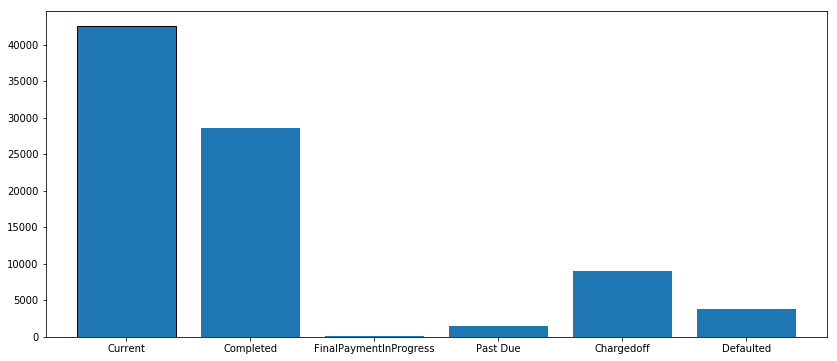

In [60]:
df['LoanStatus_new'].value_counts().sort_index().plot.bar(color = default_color,edgecolor='black',figsize=[14,6],rot=0,width=0.8);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

>Interest Rate:skewed right with a spike at 3.2

>Income range: skewed right

>Delinquencies in the last 7 years: huge intial value then decreasing.  Needed to do a log transformation of the y-axis

>On time Payments:skewed right with a few spikes. Corresponds with the amount of the loans

>Credit Score Range Upper:normal distribution

>Listing Category: Relatively random

>Original Loan amount: spikes at the multiples of $5000, median value $6500, Mean $8338 Q3-$12000

>Loan status:Highest is the current and then the completed status



### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

>I didn't expect the spikes in the loan amounts graph but of course it makes sense now that I think about it.Same with the on-time payment spikes at the 12,36,and 60 values. I really didn't anticipate the spike in the interest rate graph and still don't know why there is that spike. Hopefully my investigation might bring clarity.

> One wrangling adjustment was that I had to eliminate the spaces in columns to get the Listing Categories to graph. I replaced them with underscores so that the code would be able to read it. 

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [61]:
numeric_vars = ['BorrowerRate', 'CreditScoreRangeUpper', 'LoanOriginalAmount']
categoric_vars = ['IncomeRange', 'DelinquenciesLast7Years', 'OnTimeProsperPayments','ListingCategory','LoanStatus']

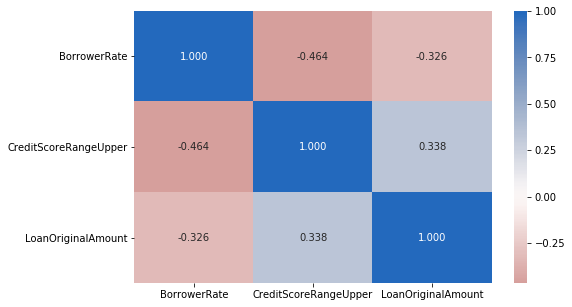

In [62]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

In [63]:
#looks like the relationship between Interest Rate and Credit Score might be interesting to look at more closely


ValueError: max must be larger than min in range parameter.

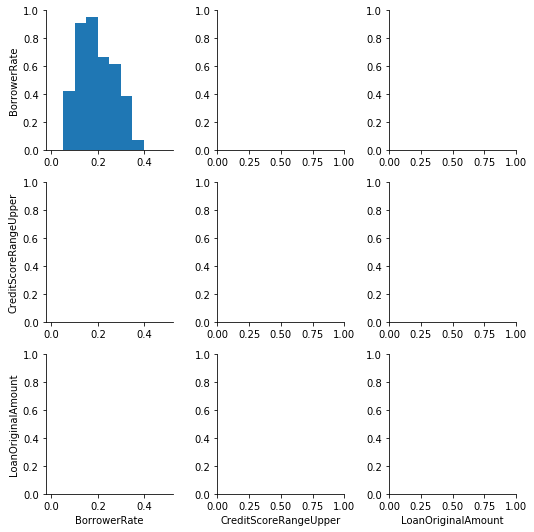

In [64]:
g = sb.PairGrid(data = df, vars = ['BorrowerRate', 'CreditScoreRangeUpper', 'LoanOriginalAmount'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);




### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!



In [ ]:
 #Now let's look at on-time payments
binsize = 10
bins = np.arange(0, df['OnTimeProsperPayments'].max()+binsize, binsize)


plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'OnTimeProsperPayments', bins = bins)
plt.xlabel('On Time Prosper Payments')
plt.xticks(rotation=90)
plt.show()